In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind, shapiro, probplot
import matplotlib.colors as clrs
import pandas as pd
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from pathlib import Path
#设置数据文件夹路径
DATA = Path().resolve()  / 'data'

# 实验设计和方差分析简介

实验：Chemitech公司开发了一种新的城市供水过滤系统。新过滤系统的部件需要从几家供应商处购买，然后由Chemitech公司设在南加州哥伦比亚市的工厂配置这些部件。

考虑了各种可能的装配方法后，工程部将范围缩小至A B C三种方法。

公司希望确定：哪种装配方法能使每周生产的过滤系统的数量最多

- 因子：引起关注的自变量的另一个称谓
- 处理：因子的不同水平
- 单因子实验：只涉及有K个总体或处理的一个因子的实验
- 响应变量：引起关注的应变量的另一个称谓
- 实验单元：实验中引起关注的研究对象
- 完全随机化试验：处理被随机地指派给实验单元的一种实验设计

在上述实验中：
- 装配方法是独立变量（因子）
- 对应因子的三种装配方法是说这一实验有三个处理
- 因此该公司的问题是单因子实验：只涉及一个定性因子（装配方法）
- 三个处理确定了实验的三个总体：使用A方法的全体工人 B方法的全体工人 C方法的全体工人
- 对于每个总体，响应变量是：每周装配的过滤系统的数量
- 假设公司随机抽取了三名工人随机的指派实行一种装配方法
- 实验单元就是三名随机抽取的工人  有三个实验单元 随机指派处理给实验单元就是完全随机化设计
- 抽15个实验单元——>每种独立变量处理随机的指派给5个实验单位——>三个总体 $n_1=5$ $n_2=5$ $n_3=5$

统计研究分为实验性研究与观测性研究
- 实验性研究中：数据是通过实验产生的
    1. 首先要确定我们感兴趣的变量开始
    2. 然后确定并控制一个或多个其他变量,这些其他变量与我们感兴趣的变量是相关的
    3. 与此同时，收集这些变量是如何影响我们感兴趣的那一个变量的数据
- 观测性研究中：数据是通过抽样调查产生的，而不是控制一项实验来获取数据的

本章主要介绍三种类型的实验设计：完全随机化设计、随机化区组设计、析因实验

对于每一种实验设计，我们将说明，方差分析（ANOVA）的统计方法如何能用于现有数据的分析 同样也可使用ANOVA来分析通过观察性研究得到的数据

- 在第1部分，将介绍实验性研究的基本原理，并且将说明如何将这些基本原理应用到完全随机化的设计中
- 第2部分中，将说明如何应用ANAVA来分析完全随机化实验设计的数据
- 之后的几个部分， 讨论多重比较方法和另外两个有广泛应用的实验设计：随机化区组设计和析因实验

In [132]:
chemitech = pd.read_csv(DATA/'Chemitech.csv')
chemitech

,Method A,Method B,Method C
0,58,58,48
1,64,69,57
2,55,71,59
3,66,64,47
4,67,68,49


In [111]:
chemitech.std()

Method A    5.244044
Method B    5.147815
Method C    5.567764
dtype: float64

# 单因素方差分析

单因素方差分析（One-way Anova）与 t 检验的用途很类似：
1. 都需要样本数据符合正态分布；
2. 都是检验样本均值是否有显著差异；
3. 都需要满足方差齐性要求（方差不齐没有可比性）；
4. 都是针对单因子进行分析。

t 检验胜在用起来方便简单，但是有以下两个局限：
1. t 检验最多只能研究两个样本组（就是定性变量里面的二值变量）
2. t 检验的结果能告诉我们因子是否显著，但是该因子的关键性不知道（也就是因子对结果的影响程度），通过T检验可能会找到 10 个显著因子，但是这些因子对输出的影响度不同，其中可能只有 5 个或更少非常关键。

单因素方差分析就是克服这两个局限的方法。

单因素方差分析就是只针对一个因子进行方差分析。方差分析是建立在三项假定的基础上进行的：

1. 样本数据符合正态分布；
2. 样本数据满足方差齐性要求；
3. 数据相互独立。

单因素方差分析，是一种用于检验三组以上变量之间统计显著性的方法。

为什么检测三组以上变量，我们还管这个分析方法叫**单因素**方差分析呢？

因为虽然我们有三组以上的数据，但实际上这三组数据都是根据同一个定性变量进行区分的。

最典型的例子就是，如果我们要调查不同教育水平的网民，上网时长是否有区别，

那我们可以根据“教育程度”将数据分为不同组别：初中及以下、高中、本科、研究生及以上，

虽然我们把数据分为四组，但实际上这只是同一个定量数据：**教育水平**的不同取值，

最后我们获取的数据实际上只有两个维度：定量变量：上网时长；定性变量：教育水平

**单因素**指的是，除了一个定量因变量之外，我们只有**一个**定量变量，而不是定量变量分为多少组。

如果我们现在除了一个定量因变量之外，有两个定性变量，那此时适用的是双因素方差分析。

如果我们现在除了一个定量因变量之外，有至少一个定性变量，和至少两个定量变量，那此时适用的是协方差分析。

由于单因素方差分析是一种综合测试，所以会把数据集作为一个整体进行检验。

如果我们得出的结果是统计显著的，我们无法确定是哪一组与其他组别的区别是统计显著的。

如果我们需要区分是哪一组的区别是统计显著的，还需要借助其他方法如 POST-HOC 检验。

## 数据收集
在实验内得到三个样本数据：
- $\mu_1$: 使用装配方法A每周生产的过滤系统的数量
- $\mu_2$: 使用装配方法B每周生产的过滤系统的数量
- $\mu_3$: 使用装配方法C每周生产的过滤系统的数量

问题在于：观察到这三个样本均值之间的差异是否足够大，以致于能够得出结论——对应于三种装配方法的总体均值是不同的

因此：试图使用样本均值来检验下面的假设
- $H_0:\mu_1=\mu_2=\mu_3$
- $H_\alpha:总体均值不全相等$

接下来：利用方差分析来确定三个样本值之间观察到的差异是否足够大可以拒绝 $H_0$

## 方差分析的假定

方差分析的假定需要三个假设：
1. 对于每个总体，响应变量服从正态分布。在该公司试验中，意味着每一种装配方法，每周生产的过滤系统的数量（响应变量）必须服从正态分布
2. 响应变量的方差，记作 $\sigma^2$ ，对所用总体都是相同的。在该公司试验中，意味着对于每一种装配方法 每周生产的过滤系统数量的方差必须是相同的
3. 观测值必须是独立的。在该公司试验中，意味着 每一实验单位每周产生的响应变量必须与任何其他工人每周生产的过滤系统数量独立


## 方差齐性检验

方差齐性检验，主要用于检验两个或两个以上样本间的方差是否相同，做单因子方差分析之前需要进行方差齐性检验。

先讲讲什么是方差齐性，方差齐性是指不同组间的总体方差是一样的。那为什么方差分析的前提是要组间的总体方差保持一致呢？先想想方差分析是做什么呢？方差分析是用来比较多组之间均值是否存在显著差异。那如果方差不一致，也就意味着值的波动程度是不一样的，如果此时均值之间存在显著差异，不能够说明一定是不同组间处理带来的，有可能是大方差带来大的波动；如果方差一样，也就意味着值的波动程度是一样的，在相同波动程度下，直接去比较均值，如果均值之间存在显著差异，那么可以认为是不同组间处理带来的。

方差齐性检验是对两组样本的方差是否相同进行检验。检验思想与均值之间差异性检验是一样的。常用的方法有：方差比、Hartley检验、Levene检验、BF法、Bartlett检验。

1. 方差比

    方差比顾名思义就是两组方差的比，用较大一组的方差除较小一组的方差，最后得到一个F值，然后根据F值的大小来判断两组之间的方差是否相等。F值越大，则认为两组方差越不相等。

2. Hartley检验

    Hartley检验与方差比的思想比较类似，差别在于Hartley检验用于多组方差的检验，用多组中最大的方差除最小的方差，得到一个F值，然后通过F值的判断来对方差齐性进行判断。

3. Levene检验

    Levene检验是将每个值先转换为为该值与其组内均值的偏离程度，然后再用转换后的偏离程度去做方差分析，即组间方差/组内方差。
    
    在这里关于组内均值有多种计算方式：平均数、中位数、截取平均数(去掉最大和最小值后求平均)。

4. BF法

    Levene检验最开始计算组内均值的时候只是用了组内平均数，后来又有名叫Brown和Forsythe的两位前辈对齐进行了改造，添加了中位数和截取均值的方法，简称BF法。


    这个在Python里面用的也是levene函数，通过调整参数的取值即可。

5. Bartlett检验

    Bartlett检验的核心思想是通过求取不同组之间的卡方统计量，然后根据卡方统计量的值来判断组间方差是否相等。该方法极度依赖于数据是正态分布，如果数据非正态分布，则的出来的结果偏差很大。

## 方差分析：概念性综述

如果三个总体均值相等，我们可以期望三个样本均值彼此之间很接近，

事实上，三个样本均值相互越接近，推断总体均值不等的证据就越缺乏说服力。

即：样本均值差异越大，我们推断总体均值不等的证据就越有说服力，换句话说，
- 如果样本均值的变异性“小”，则支持 $H_0$
- 如果样本均值的变异性“大”，则支持 $H_\alpha$

如果原假设 $H_0:\mu_1=\mu_2=\mu_3$ 为真，则可以利用样本均值之间的变异性（标准误差）建立 $\sigma^2$ 的一个估计。

原理：来自正态总体的容量为 $n$ 的一个简单随机样本的样本均值 $\bar x$ 的抽样分布仍然服从正态分布，其均值为$\mu$，（标准误差）方差为 $\sigma^2/n$

In [112]:
chemitech.mean()

Method A    62.0
Method B    66.0
Method C    52.0
dtype: float64

数据：三个样本均值分别为：$\bar x_1=62, \bar x_2=66, \bar x=52$

在该公司实验中，当样本容量相等时，$\bar x$的抽样分布的均值的最佳估计是三个样本均值的均值或算术平均数：即——该实验中，$\bar x$抽样分布的均值的一个估计值是$(62+66+52)/3=60$, 该股机制为总样本均值

$\bar x$的抽样分布的（标准误差）方差$\sigma_{\bar x}^2$的估计可以由三个样本均值的方差得出：
$$s_{\bar x}^2 = \frac{(62-60)^2+(66-60)^2+(52-60)^2}{3-1}=52$$

In [113]:
chemitech.mean().var()

52.0

由公式$\sigma_{\bar x}^2 = \sigma^2/n$得：
$\sigma^2的估计值（组间方差）=n\times (\sigma_{\bar x}^2的估计量)=ns_{\bar x}^2=5\times 52=260$

In [114]:
chemitech.mean().var() * chemitech.shape[0]

260.0

$\sigma^2$的处理间估计的根据是：原假设为真，这种情形下，每个样本都来自同一总体，并且$\bar x$只有一个抽样分布

$\sigma^2$的处理内估计的根据是：每个样本的内部变异也会对我们得到的方差分析的结论产生影响。当我们从每个总体中抽取一个随机样本时，每个样本方差都给出了$\sigma^2$的的一个无偏估计。将$\sigma^2$的个别估计组合或合并成一个总的估计，用这种方法得到的$\sigma^2$的估计称为$\sigma^2$的合并估计或处理内估计

$$\sigma^2的组内方差=\frac{27.5+26.5+31}{3}=28.33$$

In [115]:
chemitech.var().mean()

28.333333333333332

- 当原假设为真，组间方差才是总体方差 $\sigma^2$的一个好的估计量
- 当原假设为假，组间方差法将高估总体方差。

这两种情形下，处理内估计都是总体方差的一个好的估计量。因此：原假设为真时，两个估计量应该很接近，比值接近1；如果原假设为假，则处理间估计将大于处理内估计，比值也将是大的

总的来说：ANOVA 背后的逻辑是以**共同方差 $\sigma^2$ 的两个独立的估计量**为基础：
- 一个是以样本均值之间的变异性为依据，
- 另一个估计量是以每个样本内部的变异性为依据，
- 通过比较这两个估计量，就能确定总体均值是否相等。

## 方差分析和完全随机化实验设计
本节中，将说明 对于一个完全随机化实验设计 如何应用方差分析来检验$k$个总体均值是否相等的问题 被检验的假设的一般形式为:
- $H_0: \mu_1 = \mu_2 = ... = \mu_k$
- $H_\alpha$: k 个总体的均值不全相等

式中，$\mu_j$ 代表的是第 $j$ 个总体的均值

假定从$k$个总体或处理中的每一个抽取一个容量为$n_j$的简单随机样本 对于得到的样本数据 令$x_ij$代表的第$j$个处理的第$i$个观测值  $n-j$代表第$j$个处理的观测值个数 $\bar x_j$代表的$j$个处理的样本均值  $s_j^2$代表第$j$个处理的样本方差  $s_j$代表第$j$个处理的样本标准差

第$j$个处理的样本均值与样本方差的计算公式：
$$\bar x_j = \frac{\sum\limits_{n=1}^{n_j} x_{ij}}{n_j}$$

总样本均值 记为$\bar{\bar x}$ 等于所有观测值之和除以观测值的总个数

$$\bar{\bar x} = \frac{\sum_{j=1}^{k} \sum_{n=1}^{n_j} x_{ij}}{n_T}$$

式中 $n_T=n_1+n_2+ ... + n_k$

若每个样本的容量是相等的 都为$n$ 则$n_T=kn$ 在这种情形下 简化为

$$\bar {\bar x} = \frac{\sum\limits_{j=1}^k \bar x_j}{k}$$

在 Chemitech 的例子中，因为每个样本的样本量都是 5，因此我们可以直接计算总体均值 $\mu$：

In [116]:
chemitech.mean().mean()

60.0

## 总体方差的处理间估计

总体方差的处理间估计原理：原假设为真，在这种情形下，每个样本都来自同一个总体，并$\bar x$只有一个抽样分布

$\sigma^2$的这个估计量为均方处理（mean square due to treatments, MSTR)
$$MSTR = \frac{\sum\limits_{j=1}^{k} n_j (\bar x_j - \bar {\bar x})^2}{k-1}$$

处理平方和：（sum of squares due to treatments, SSTR)
$$SSTR = \sum\limits_{j=1}^k n_j(\bar x_j - \bar {\bar x})^2$$

上述试验中
$$SSTR = 5 \times (62-60)^2 + 5 \times (66-60)^2 + 5 \times (52-60)^2 = 520$$
$$MSTR = \frac{SSTR}{K-1} = \frac{520}{2} = 260$$

## 总体方差的处理间估计

总体方差的处理间估计原理：每个样本的内部变异也会对我们得到的方差分析的结论产生影响。

当我们从每个总体中抽取一个随机样本时，每个样本方差都给出了 $\sigma^2$ 的的一个无偏估计。

将 $\sigma^2$ 的个别估计组合或合并成一个总的估计，用这种方法得到的 $\sigma^2$ 的估计称为 $\sigma^2$ 的合并估计或处理内估计

误差平方和 (sum of squares due to error)

$$SSE = \sum\limits_{j=1}^k (n_j - 1) s_j^2$$

均方误差（mean square due to error)
$$MSE = \frac{\sum\limits_{j=1}^k (n_j - 1) s_j^2}{n_T-k}$$

上述试验中
$$SSE = (5-1)\times 27.5 + (5-1) \times 26.5 + (5-1)\times 31 = 340$$
$$MSE = \frac{340}{15-3} = 28.33$$

## 方差估计量的比较：$F$检验
k个总体均值相等的检验
$H_0: \mu_1 = \mu_2 = ... = \mu_k$

检验统计量：

$$F = \frac{MSTR}{MSE}$$

式中，$F_{\alpha}$ 是分子自由度为 $k-1$, 分母自由度为 $n_T-k$ 时，$F$ 分布的上侧曲线下方面积为 $\alpha$ 的 $F$ 值

拒绝法则：
- p-值法：如果 $p- \le \alpha$，则拒绝 $H_0$
- 临界值法：如果 $F \ge F_alpha$，则拒绝 $H_0$

计算可得，案例的 $F = \frac{260}{28.33} = 9.18$，对应的 $p- = 0.004$ 小于 $\alpha = 0.05$，因此我们可以拒绝零假设，认为三个组的总体均值是不相等的。

下面我们用 Python 验证一下计算结果：

In [117]:
f_oneway(chemitech['Method A'], chemitech['Method B'], chemitech['Method C'])

F_onewayResult(statistic=9.176470588235295, pvalue=0.0038184120755124806)

由于 `scipy` 提供的统计信息有限，如果你想要了解更多的统计量，可以使用 `statsmodels` 的方差分析函数，[参考](https://www.pythonfordatascience.org/anova-python/)

实际上，清洗好了数据集之后，我们只需要用一行代码就能使用 `statsmodels` 进行单因子方差分析：

`ols("outcome_variable ~ independent_variable", data= data_frame).fit()`

上面那行伪代码是线性回归的代码，默认的独立变量是定量变量，单因素方差分析的独立变量是定性变量，因此我们需要标识一下：

`ols("outcome_variable ~ C(independent_variable)", data= data_frame).fit()`

需要注意的是，`anova_lm`函数里面的`typ`参数指定平方和的计算方式，具体解释在[这里](https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html)

如果`typ`参数为 3，方差分析时需要做一些[调整](https://www.pythonfordatascience.org/anova-sum-of-squares-statsmodels-python/).

In [128]:
chemitech = pd.read_csv(DATA/'Chemitech.csv')
chemitech['index'] = chemitech.index
chemitech = pd.melt(chemitech, id_vars=['index'], value_vars=['Method A', 'Method B', 'Method C'])
chemitech[['temp','Method']] = chemitech.variable.str.split(pat=' ',expand=True)
chemitech = chemitech.drop(['index', 'variable', 'temp'], axis=1)
chemitech.head()

,value,Method
0,58,A
1,64,A
2,55,A
3,66,A
4,67,A


In [ ]:
model = smf.ols('value ~ C(Method)', data=chemitech).fit()

# 是否满足假设检验的前提

如果想要确保数据分析结果是可信的，在进行分析之前，我们需要先检查数据集是否满足假设检验的前提。[详见](https://www.pythonfordatascience.org/parametric-assumptions-python/)

## 独立性

在进行研究设计的时候，就应该提前考虑独立性这个问题。

这意味着数据集的每一个组都是互相独立的：

- 每个统计样本只能属于某一个组，不能同时属于两个组
- 统计样本没有被重复计量

在这个案例里面，数据是满足独立性的。

## 正态分布

常用的正态分布检验方法是 Shapiro-Wilk 方法。我们可以直接用这个函数来检验：

In [122]:
shapiro(model.resid)

ShapiroResult(statistic=0.9175854921340942, pvalue=0.1769532859325409)

p-value > 0.05，意味着数据是正态分布的。

另一种检验方法是视觉检验（我刚开始看到这里也觉得很惊奇）。

针对样本量非常大的情况，Shapiro-Wilk 方法往往会拒绝零假设（想想之前是不是也碰到过对样本量敏感的情况？）

因为随着样本量的增加，特别微小的差异也会被样本数量放大。

其中一种视觉检验方法就是结合正态概率图和 $R^2$ 来评估观测值和理论分布（在这里是正态分布）的相关程度。

[相关资料](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3676.htm)

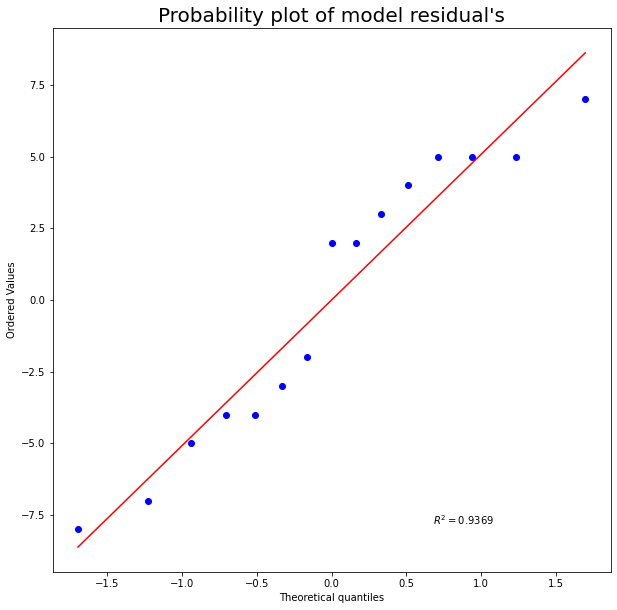

In [125]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

当前的案例就是一个比较特殊的情况：统计量的结果表明数据集是服从正态分布的，但是正态分布图的结果却表示数据集并不服从正态分布。

由于我们的数据量非常小，因此我们采信统计量的结果。

## 方差齐性检验

前面我们也介绍过了很多方差齐性检验的方法，就不赘述了：

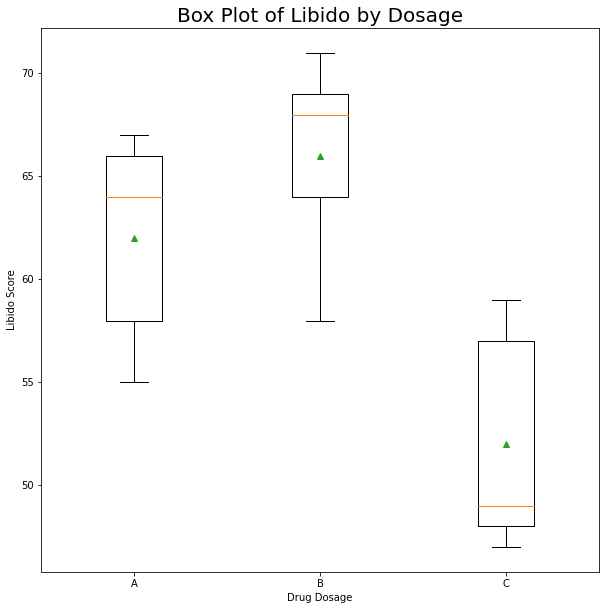

In [129]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Libido by Dosage", fontsize= 20)
ax.set

data = [chemitech['value'][chemitech['Method'] == 'A'],
        chemitech['value'][chemitech['Method'] == 'B'],
        chemitech['value'][chemitech['Method'] == 'C']]

ax.boxplot(data,
           labels= ['A', 'B', 'C'],
           showmeans= True)

plt.xlabel("Drug Dosage")
plt.ylabel("Libido Score")

plt.show()

方差齐性分析通过分析方差来验证是否满足假设检验的前提，其中：

- 橙色线：中位数
- 绿色块：组内均值

如何处理方差齐性问题，这里就不赘述了。

In [96]:
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Method),520.0,2.0,9.176471,0.003818
Residual,340.0,12.0,NaN,NaN


- Df 是自由度（degrees of freedom）
- Sum Sq 是平方和（sum of squares）
- Mean Sq 是均方误差（meansquares，即 mean-squared deviations 的缩写）
- F value是 F 统计量。

In [97]:
"""
The function below was created specifically for the one-way ANOVA table 
results returned for Type II sum of squares
"""
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [98]:
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Method),520.0,2.0,260.000000,9.176471,0.003818,0.604651,0.521576
Residual,340.0,12.0,28.333333,NaN,NaN,NaN,NaN


## $ANOVA表$
$ANOVA$ 表可以用于观测性研究，也可以用于实验性研究

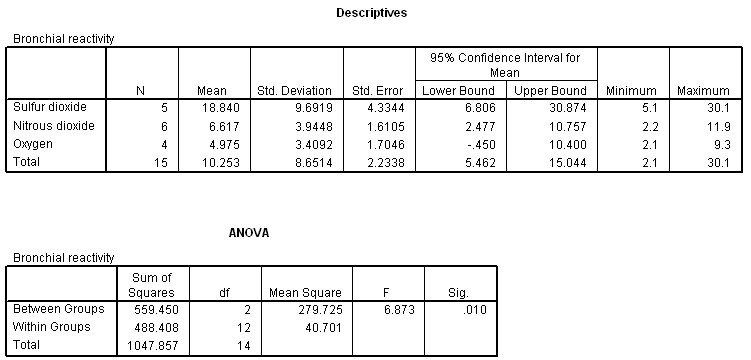

# 多重比较方法

当我们应用方差分析方法检验 $k$ 个总体均值是否相等时，拒绝原假设只能让我们得出 $k$ 个总体的均值**不全相等**的结论。

使用多重比较方法，可以确定 $k$ 个均值中间**到底哪几个均值**之间存在差异，在成对的总体均值之间进行比较。

## $Fisher$的$LSD$方法

基于检验统计量$\bar x_i - \bar x_j$的$Fisher$的$LSD$方法
- $H_0: \mu_i = \mu_j$，$H_\alpha: \mu_i \neq \mu_j$
- 检验统计量： $\bar x_i - \bar x_j$
- 显著性水平 $\alpha$ 下的拒绝法则
- 如果 $|\bar x_i - \bar x_j| \ge LSD$, 则拒绝 $H_0$

式中：

$$LSD = t_\alpha/2 \sqrt{MSE(\frac{1}{n_i}+\frac{1}{n_j})}$$

应用Fisher的LSD方法的两个总体均值之差的置信区间估计

$\bar x_i - \bar x_j \pm LSD$

其中, $t_{\alpha}$ 是自由度为 $n_T-k$ 时，使 $t$ 分布的上侧面积为 $\alpha/2$ 的 $t$ 值

## HSD

In [101]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(chemitech['value'], chemitech['Method'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,4.0,0.482,-4.9814,12.9814,False
A,C,-10.0,0.0292,-18.9814,-1.0186,True
B,C,-14.0,0.0035,-22.9814,-5.0186,True


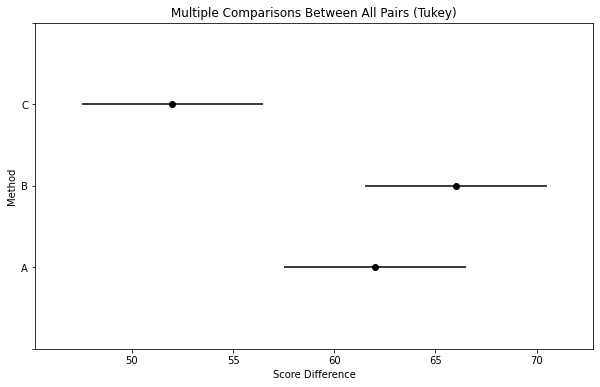

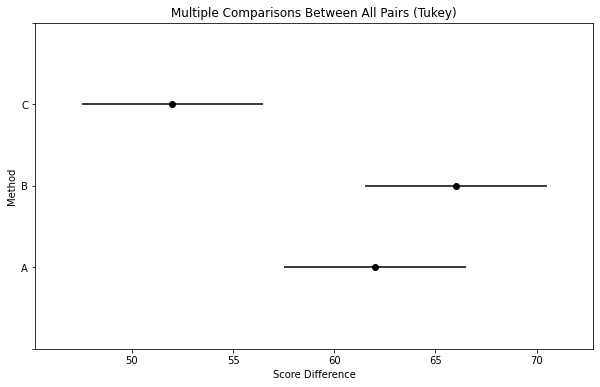

In [102]:
post_hoc_res.plot_simultaneous(ylabel= "Method", xlabel= "Score Difference")

## Bonferroni

In [130]:
comp = mc.MultiComparison(chemitech['value'], chemitech['Method'])
tbl, a1, a2 = comp.allpairtest(ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
A,B,-1.2172,0.2582,0.7747,False
A,C,2.9235,0.0192,0.0576,False
B,C,4.1284,0.0033,0.0099,True


## Šidák

In [131]:
tbl, a1, a2 = comp.allpairtest(ttest_ind, method= "sidak")
tbl

group1,group2,stat,pval,pval_corr,reject
A,B,-1.2172,0.2582,0.5919,False
A,C,2.9235,0.0192,0.0565,False
B,C,4.1284,0.0033,0.0099,True


## 第一类错误概率

我们开始讨论 Fisher 的 LSD 方法的前提是，方差分析为我们提供了拒绝总体均值相等的原假设的统计证据。

在这种情形下，我们说明了如何使用 Fisher 的 LSD 方法来确定，总体均值之间的差异到底出现在哪些均值之间。

在技术上，Fisher 的 LSD 方法被称为保护性或限制性 LSD 检验，因为只有当我们首先找到一个用于方差分析的显著的 F 值时，我们才使用LSD检验。

为了弄清楚在多重比较检验中，这种区别为什么是重要的，我们需要解释一下比较方式的第 I 类错误概率与实验方式的第I类错误概率的区别：

在 Chemitech 公司实验的例子中，我们利用 Fisher 的 LSD 方法做了三个成对的两两比较。

在每一种情形下，我们都使用 $\alpha=0.05$ 的显著性水平。因此，对每个检验，如果原假设为真，则犯第 I 类错误的概率为 $\alpha=0.05$，不犯第I类错误的概率就是 1-0.05=0.95。

在讨论多重比较方法时，我们把这个第 I 类错误的概率 $\alpha=0.05$ 称为**比较方式的第 I 类错误概率**（comparison wise Type I error rate）。

比较方式的第 I 类错误既率表示了与单个两两比较相联系的显著性水平。

现在我们考虑一个略为不同的问题。在进行三次成对的两两比较时，三次检验中至少有一次犯第 I 类错误的概率是多少？

为回答这个问题，我们注意到三次检验都不犯第 I 类错误的概率为 $(1-\alpha)^3={0.95}^3=0.8574$。

因此，至少有一次犯第I类错误的概率为 1-0.8574=0.1426。这样当我们用 Fisher 的 LSD 方法进行三次成对的两两比较时，对应的犯第I类错误概率已经不是 0.05，其实是 0.1426。

我们将这个错误概率称为总的或实验方式的第 I 类错误概率（experiment wise Type I error rate）。为避免混滑，我们将实验方式的第 I 类错误概率记为 $\alpha_{EW}$。

对于总体个数较多的问题，犯实验方式第 I 类错误的概率就会变得比较大，例如对于有5个总体，10个可能成对的两两比较的问题。在比较方式的第I类错误概率为 $\alpha=0.05$ 时，如果我们利用 Fisher 的 LSD 方法检验所有可能成对的两两比较，则犯实验方式第 I 类错误的概率将是 $1-(1-0.05)^{10}=0.40$。

在这种情形下，有实际经验的专业人员将会寻求其他方法，以更好地控制犯实验方式第 I 类错误的概率。

控制总的犯实验方式错误概率的一种方法被称为 Bonferroni 修正方法，该方法在每一次检验中都使用一个较小的比较方式错误概率。例如，如果我们想要检验  $C$ 个成对的两两比较，并希望总的犯实验方式第 I 类错误的最大概率为 $\alpha_{EW}$ ，那么我们只要简单地将犯比较方式错误的概率等于 $\alpha_{EW}/C$ 即可。

在Chemitech公司实验的例子中，如果我们想要使用 Fisher 的 LSD 方法检验所有三个成对的两两比较，并且希望犯实验方式错误的最大概率为 $\alpha_{EW}=0.05$，那么我们只要设比较方式的错误概率为 $\alpha_{EW} = 0.05/3 = 0.017$ 即可。

对于有 5 个总体，10 种可能成对的两两比较的问题，Bonferroni修正方法建议的比较方式错误概率为 $\alpha_{EW} = 0.05/10 = 0.005$。

回忆第 9 章有关假设检验的讨论，对于固定的样本容量，减少犯第 I 类错误的概率将增加犯第 Ⅱ 类错误的概率，而第 Ⅱ 类错误是指当两个总体的均值实际上不相等时，却接受了两个总体均值相等的原假设。

由于犯第 Ⅱ 类错误的风险增加，因此许多有实际经验的专业人员不愿在一个比较低的犯比较方式第 I 类错误的概率下，进行单个
的两两比较检验。

在这种情况下，还有几种其他方法如 Tukey 方法与 Duncan 多重区域检验，也可用于解决这类问题。但是究竞哪种方法是“最优的”，在统计学界存有较大争议。事实上，没有任何一种方法对所有类型的问题都是最优的。

## [复测方差分析](https://www.statology.org/repeated-measures-anova-python/)

在学习复测方差分析之前，让我们来回顾一下配对样本 t 检验：
- 配对样本 t 检验：一个二值定类变量，一个定量变量，且定量变量需要配对（如同一个患者使用药品前/使用药品后的数据）
- 配对样本 t 检验可以处理一个因变量在两个时间点的取值。

如果要检验定类因变量不是二值变量，而有三类或者更多类别，我们该采用什么方法呢？

这个情况，就是复测方差分析发挥作用的时候了。

除了满足独立、正态分布和方差齐次之外，复测方差分析还需要满足**球对称假设**：

> 对于被试者内因素的各个水平组合而言，因变量的协方差矩阵相等。球形检验(Mauchly's test of sphericity) , 适用于重复测量时，检验不同测量之间的差值的方差是否相等，用于三次以及三次以上水平的重复测量(因为两次重复测量根本就没有办法比较差值的方差,只有一个方差)。

下面我们来看看案例数据：

In [133]:
df = pd.DataFrame({'patient': np.repeat([1, 2, 3, 4, 5], 4),
                   'drug': np.tile([1, 2, 3, 4], 5),
                   'response': [30, 28, 16, 34, 14, 18, 10, 22, 24, 20, 
                                18, 30, 38, 34, 20, 44, 26, 28, 14, 30]})

#view first ten rows of data 
df.head()

,patient,drug,response
0,1,1,30
1,1,2,28
2,1,3,16
3,1,4,34
4,2,1,14


In [134]:
from statsmodels.stats.anova import AnovaRM
print(AnovaRM(data=df, depvar='response', subject='patient', within=['drug']).fit())

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
drug 24.7589 3.0000 12.0000 0.0000



In this example, the F test-statistic is 24.7589 and the corresponding p-value is 0.0000. Since this p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in mean response times between the four drugs.